# Load 10XGv2 human/mouse 6K cell mixture data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  


adata1 = pd.read_table('../10XGv2_hgmm6k_out/outs/raw_gene_bc_matrices/human_10XGv2_primary/matrix.mtx',sep=" ",skiprows=3,header=None)
cellID = pd.read_table('../10XGv2_hgmm6k_out/outs/raw_gene_bc_matrices/human_10XGv2_primary/barcodes.tsv',sep="\t",header=None)
adata2 = pd.read_table('../10XGv2_hgmm6k_out/outs/raw_gene_bc_matrices/mouse_10XGv2_primary/matrix.mtx',sep=" ",skiprows=3,header=None)


In [2]:
from scipy.stats import gaussian_kde

In [3]:
human = pd.read_table('../10XGv2_hgmm6k_out/outs/filtered_gene_bc_matrices/human_10XGv2_primary/barcodes.tsv',sep="\t",header=None)
mouse = pd.read_table('../10XGv2_hgmm6k_out/outs/filtered_gene_bc_matrices/mouse_10XGv2_primary/barcodes.tsv',sep="\t",header=None)
combine = list(set(human.iloc[:,0]) | set(mouse.iloc[:,0]))
print("Number of human cells identified:",len(human))
print("Number of mouse cells identified:",len(mouse))
print("Total number of cells identified:",len(combine))
adata1.columns = ['GENE','BC','COUNTS']
adata2.columns = ['GENE','BC','COUNTS']

Number of human cells identified: 3530
Number of mouse cells identified: 3392
Total number of cells identified: 6751


# Generate an empty data frame for all the cell barcodes detected

In [4]:
stat = pd.DataFrame({'barcodes':combine,'counts_human':[0]*len(combine),'counts_mouse':[0]*len(combine),'counts_total':[0]*len(combine)})
stat.set_index('barcodes', inplace=True)

# Calculate total transcript counts for each identified human/mouse cell barcode

In [5]:
for i in combine:
    bci = cellID.index[cellID.iloc[:,0] == i].tolist()
    hcounti = adata1[adata1.iloc[:,1] == bci[0]+1]
    mcounti = adata2[adata2.iloc[:,1] == bci[0]+1]
    stat.loc[i,'counts_human'] = hcounti['COUNTS'].sum()
    stat.loc[i,'counts_mouse'] = mcounti['COUNTS'].sum()
    stat.loc[i,'counts_total'] = stat.loc[i,'counts_human'] + stat.loc[i,'counts_mouse']

In [6]:
stat.loc['AAACCTGCAGACAGGT-1']

counts_human    45214
counts_mouse      387
counts_total    45601
Name: AAACCTGCAGACAGGT-1, dtype: int64

# Generate scatterplot to show counts of human transcripts vs. counts of mouse transcripts for each cell barcode

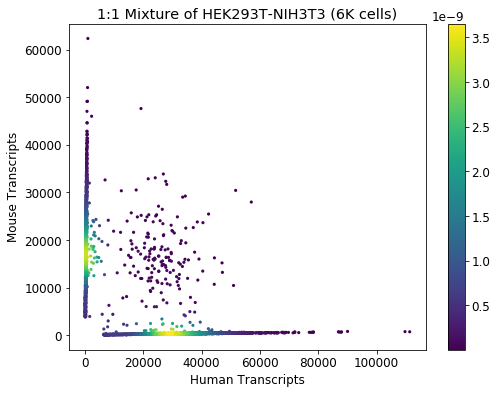

In [18]:
xy = np.vstack([stat.loc[:,'counts_human'], stat.loc[:,'counts_mouse']])
z = gaussian_kde(xy)(xy)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,6))
plt.scatter(stat.loc[:,'counts_human'], stat.loc[:,'counts_mouse'], c=z, s=10, edgecolor='')
plt.title('1:1 Mixture of HEK293T-NIH3T3 (6K cells)')
plt.xlabel('Human Transcripts')
plt.ylabel('Mouse Transcripts')
plt.colorbar()

# Plot number of transcripts detected in human and mouse cells

Text(0,0.5,'Number of transcripts')

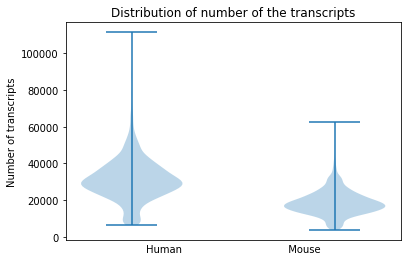

In [8]:
adata_mouse = stat[(stat['counts_human']<stat['counts_total']*0.05)]
adata_human = stat[(stat['counts_mouse']<stat['counts_total']*0.05)]
#len(adata_mouse['counts_mouse'])
#len(adata_human['counts_human'])
plt.violinplot(dataset = [adata_human[:]['counts_human'], adata_mouse[:]['counts_mouse']])
plt.title('Distribution of number of the transcripts')
plt.xticks([])
plt.xlabel('Human                                  Mouse')
plt.ylabel('Number of transcripts')

In [9]:
stat.to_csv('../comparison_hgmm6k/counts_cellranger.csv', sep=',')